# Movie Data Analysis with PySpark

This Jupyter Notebook performs a comprehensive analysis of movie data fetched from the TMDB API using PySpark. 

It leverages functions defined in `functions.py` to fetch, clean, and analyze data, calculate KPIs, perform advanced filtering, compare franchises vs. standalone movies, analyze franchises and directors, and generate visualizations.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MovieDataAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

25/04/24 23:41:39 WARN Utils: Your hostname, Hakeems-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
25/04/24 23:41:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 23:41:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from functions import (
    build_schema,              # Function to define the schema for movie data
    fetch_movie_data,               # Function to fetch movie data from TMDB API
    clean_movie_data,               # Function to clean and transform the dataframe
    kpi_ranking,                    # Function to calculate key performance indicators
    advanced_search,                # Function to perform advanced movie filtering
    franchise_vs_standalone,        # Function to compare franchise and standalone movies
    analyze_franchise,              # Function to analyze franchise performance
    analyze_directors,               # Function to evaluate director performance
    plot_revenue_vs_budget,
    plot_roi_by_genre,
    plot_popularity_vs_rating,
    plot_yearly_box_office,
    plot_franchise_vs_standalone
)

## Fetching Raw Movie Data

- **Define movie IDs:** Creates a list of specific TMDB movie IDs to analyze.

- **Build schema:** Uses `build_schema()` to define the structure of the DataFrame.

- **Fetch data:** Uses `fetch_movie_data()` to collect metadata for each movie from the TMDB API.

- **Preview data:** Displays the schema and first few records of the fetched raw data.

In [3]:
# Define movie IDs
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397,
             420818, 24428, 168259, 99861, 284054, 12445,
             181808, 330457, 351286, 109445, 321612, 260513]

# Build schema
schema = build_schema()

# Fetch movie data
raw_data = fetch_movie_data(movie_ids, schema)

# Display schema
print("Raw Data Schema:")
raw_data.printSchema()

# Display first few rows
print("\nSample Raw Data:")
raw_data.show(2, truncate=False, vertical=True)

2025-04-24 23:41:42,374 - WARNING - Failed to fetch movie ID 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=fc67bc86d72331280543a2761748f0e6&append_to_response=credits


Raw Data Schema:
root
 |-- id: integer (nullable = false)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- revenue: long (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- overview: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- belongs_to_collection: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- production_companies: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |   

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Cleaning the Movie Dataset

- **Clean raw data:** Applies `clean_movie_data()` to standardize column names, process JSON-like fields, and convert data types.

- **Handle zeros:** Replaces zero values in budget, revenue, and runtime with NULL.

- **Calculate metrics:** Adds financial metrics like profit and ROI (return on investment).

- **Standardize fields:** Unifies genre and production country formats for consistency.

- **Preview cleaned data:** Displays the schema and first few records of the cleaned dataset.

In [4]:
# Clean the raw data
cleaned_data = clean_movie_data(raw_data)

# Cache the cleaned DataFrame for performance
cleaned_data.cache()

# Display schema
# print("Cleaned Data Schema:")
# cleaned_data.printSchema()

# Display schema in a concise way
print("Cleaned Data Schema (Top-Level Fields):")
for field in cleaned_data.schema.fields:
    print(f"- {field.name}: {field.dataType.simpleString()}")

# Display first few rows
print("\nSample Cleaned Data:")
cleaned_data.show(5, truncate=20)

Cleaned Data Schema (Top-Level Fields):
- id: int
- title: string
- tagline: string
- release_date: date
- genre_names: string
- collection_name: string
- original_language: string
- budget_millions: double
- revenue_millions: double
- production_companies_str: string
- production_countries_str: string
- vote_count: int
- vote_average: double
- popularity: double
- runtime: int
- overview: string
- spoken_languages_str: string
- poster_path: string
- cast_names: string
- cast_size: int
- director: string
- crew_size: int
- profit: double
- roi: double

Sample Cleaned Data:


+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+---------------+----------------+------------------------+------------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------------+-----------------+
|    id|               title|             tagline|release_date|         genre_names|     collection_name|original_language|budget_millions|revenue_millions|production_companies_str|production_countries_str|vote_count|vote_average|popularity|runtime|            overview|spoken_languages_str|         poster_path|          cast_names|cast_size|            director|crew_size|            profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+---------------+----------------+--------------------

## Key Performance Indicators (KPIs)

- **Rank movies:** Uses `kpi_ranking()` to rank movies by revenue, displaying the top 5.

- **Filter and rank:** Optionally filters movies by a metric (e.g., vote count) before ranking.

In [5]:
print("\nTop 5 Movies by Revenue:")
kpi_ranking(cleaned_data, 'revenue_millions', n=5, top=True).select(
    'title', 'revenue_millions', 'budget_millions'
).show(truncate=False)

print("\nTop 5 Movies by Budget:")
kpi_ranking(cleaned_data, 'budget_millions', n=5, top=True).select(
    'title', 'budget_millions', 'revenue_millions'
).show(truncate=False)

print("\nTop 5 Movies by Profit:")
kpi_ranking(cleaned_data, 'profit', n=5, top=True).select(
    'title', 'profit', 'revenue_millions', 'budget_millions'
).show(truncate=False)

print("\nBottom 5 Movies by Profit:")
kpi_ranking(cleaned_data, 'profit', n=5, top=False).select(
    'title', 'profit', 'revenue_millions', 'budget_millions'
).show(truncate=False)

print("\nTop 5 Movies by ROI (Budget >= 10M):")
kpi_ranking(cleaned_data, 'roi', n=5, top=True, filter_col='budget_millions', filter_val=10).select(
    'title', 'roi', 'revenue_millions', 'budget_millions'
).show(truncate=False)

print("\nBottom 5 Movies by ROI (Budget >= 10M):")
kpi_ranking(cleaned_data, 'roi', n=5, top=False, filter_col='budget_millions', filter_val=10).select(
    'title', 'roi', 'revenue_millions', 'budget_millions'
).show(truncate=False)

print("\nTop 5 Most Voted Movies:")
kpi_ranking(cleaned_data, 'vote_count', n=5, top=True).select(
    'title', 'vote_count', 'vote_average'
).show(truncate=False)

print("\nTop 5 Highest Rated Movies (Vote Count >= 10):")
kpi_ranking(cleaned_data, 'vote_average', n=5, top=True, filter_col='vote_count', filter_val=10).select(
    'title', 'vote_average', 'vote_count'
).show(truncate=False)

print("\nBottom 5 Lowest Rated Movies (Vote Count >= 10):")
kpi_ranking(cleaned_data, 'vote_average', n=5, top=False, filter_col='vote_count', filter_val=10).select(
    'title', 'vote_average', 'vote_count'
).show(truncate=False)

print("\nTop 5 Most Popular Movies:")
kpi_ranking(cleaned_data, 'popularity', n=5, top=True).select(
    'title', 'popularity', 'vote_average'
).show(truncate=False)

print("\nMovies with Action Genre:")
advanced_search(cleaned_data, genre_keywords='Action', sort_by='revenue_millions').select(
    'title', 'genre_names', 'revenue_millions'
).show(truncate=False)


Top 5 Movies by Revenue:
+----------------------------+----------------+---------------+
|title                       |revenue_millions|budget_millions|
+----------------------------+----------------+---------------+
|Avatar                      |2923.706026     |237.0          |
|Avengers: Endgame           |2799.4391       |356.0          |
|Titanic                     |2264.162353     |200.0          |
|Star Wars: The Force Awakens|2068.223624     |245.0          |
|Avengers: Infinity War      |2052.415039     |300.0          |
+----------------------------+----------------+---------------+


Top 5 Movies by Budget:
+----------------------------+---------------+----------------+
|title                       |budget_millions|revenue_millions|
+----------------------------+---------------+----------------+
|Avengers: Age of Ultron     |365.0          |1405.403694     |
|Avengers: Endgame           |356.0          |2799.4391       |
|Avengers: Infinity War      |300.0          |2052.4

## Advanced Search

- **Filter movies:** Uses `advanced_search()` to find movies based on genre, cast, or director keywords.

- **Sort results:** Sorts the filtered results by a specified metric (e.g., revenue).

In [6]:
print("\nBest-Rated Science Fiction Action Movies Starring Bruce Willis:")
advanced_search(
    cleaned_data,
    genre_keywords='Science Fiction|Action',
    cast_keywords='Bruce Willis',
    sort_by='vote_average',
    ascending=False
).select(
    'title', 'genre_names', 'vote_average', 'cast_names'
).show(truncate=False)

print("\nMovies Starring Uma Thurman Directed by Quentin Tarantino:")
advanced_search(
    cleaned_data,
    cast_keywords='Uma Thurman',
    director_keywords='Quentin Tarantino',
    sort_by='runtime',
    ascending=True
).select(
    'title', 'cast_names', 'director', 'runtime'
).show(truncate=False)


Best-Rated Science Fiction Action Movies Starring Bruce Willis:
+-----+-----------+------------+----------+
|title|genre_names|vote_average|cast_names|
+-----+-----------+------------+----------+
+-----+-----------+------------+----------+


Movies Starring Uma Thurman Directed by Quentin Tarantino:
+-----+----------+--------+-------+
|title|cast_names|director|runtime|
+-----+----------+--------+-------+
+-----+----------+--------+-------+



## Franchise vs. Standalone Comparison

- **Compare groups:** Uses `franchise_vs_standalone()` to compute mean revenue, ROI, budget, popularity, and rating for franchise and standalone movies.
- **Display results:** Shows a comparison table with aggregated metrics.

In [7]:
# Compare franchise vs standalone movies
print("Franchise vs Standalone Comparison:")
franchise_vs_standalone(cleaned_data).show(truncate=False)

Franchise vs Standalone Comparison:
+------------------+-----------------+-----------+------------------+-----------------+-----------+----------+
|Mean_Revenue      |Mean_ROI         |Mean_Budget|Mean_Popularity   |Mean_Rating      |Movie_Count|Group     |
+------------------+-----------------+-----------+------------------+-----------------+-----------+----------+
|1682.6419708124997|8.000174311158963|219.875    |33.036049999999996|7.380375         |16         |Franchise |
|1765.1391585000001|9.61701827       |180.0      |47.7778           |7.438000000000001|2          |Standalone|
+------------------+-----------------+-----------+------------------+-----------------+-----------+----------+



## Franchise Analysis

- **Analyze franchises:** Uses `analyze_franchise()` to aggregate movie counts, budgets, revenues, ratings, and ROI by franchise.

- **Sort results:** Sorts franchises by total revenue to identify top performers.

In [8]:
# Top franchises by total revenue
print("Top Franchises by Total Revenue:")
analyze_franchise(cleaned_data, sort_by='total_revenue_millions').show(5, truncate=False)

Top Franchises by Total Revenue:
+------------------------+------------+---------------------+-----------+----------------------+------------------+------------------+-----------------+
|collection_name         |total_movies|total_budget_millions|budget_mean|total_revenue_millions|revenue_mean      |mean_rating       |mean_roi         |
+------------------------+------------+---------------------+-----------+----------------------+------------------+------------------+-----------------+
|The Avengers Collection |4           |1241.0               |310.25     |7776.073348           |1944.018337       |7.870750000000001 |6.364776101669278|
|Star Wars Collection    |2           |445.0                |222.5      |3400.9224540000005    |1700.4612270000002|7.0195            |7.552611613775511|
|Jurassic Park Collection|2           |320.0                |160.0      |2982.00374            |1491.00187        |6.6155            |9.426104115294118|
|Avatar Collection       |1           |237.0     

## Director Analysis

- **Analyze directors:** Uses `analyze_directors()` to aggregate movie counts, revenues, ratings, and ROI for directors of franchise movies.

- **Sort results:** Sorts directors by total revenue to highlight top performers.

In [9]:
# Top directors by total revenue
print("Top Directors by Total Revenue:")
analyze_directors(cleaned_data, sort_by='total_revenue_millions').show(5, truncate=False)

Top Directors by Total Revenue:
+-------------+---------------------+----------------------+------------------+------------------+------------------+
|director     |total_movies_directed|total_revenue_millions|mean_revenue      |mean_rating       |mean_roi          |
+-------------+---------------------+----------------------+------------------+------------------+------------------+
|Joe Russo    |2                    |4851.854139           |2425.9270695      |8.236             |7.352488220430711 |
|Anthony Russo|2                    |4851.854139           |2425.9270695      |8.236             |7.352488220430711 |
|Joss Whedon  |2                    |2924.219209           |1462.1096045      |7.5055            |5.3770639829078455|
|James Cameron|1                    |2923.706026           |2923.706026       |7.588             |12.33631234599156 |
|Chris Buck   |2                    |2727.9024849999996    |1363.9512424999998|7.2475000000000005|9.093008283333333 |
+-------------+---------

## Visualizations

- **Generate plots:** Converts Spark DataFrames to Pandas for visualization using Matplotlib.

- **Revenue vs. Budget:** Scatter plot of revenue vs. budget.

- **ROI by Genre:** Bar plot of average ROI by genre.

- **Popularity vs. Rating:** Scatter plot of popularity vs. rating.

- **Yearly Box Office:** Line plot of total revenue by release year.

- **Franchise vs. Standalone:** Bar plot comparing mean metrics.


Generating visualizations...


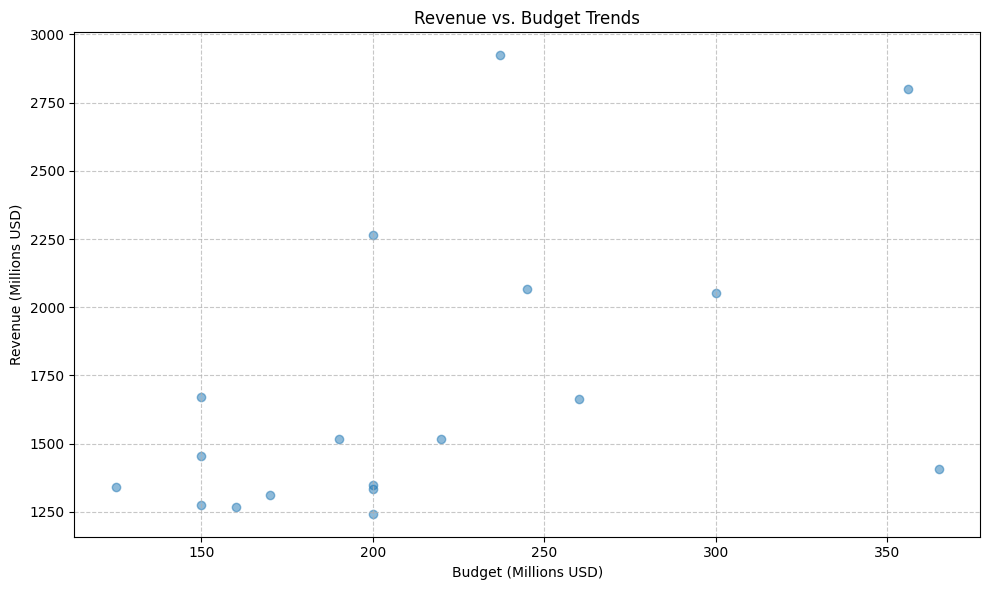

Saved revenue_vs_budget.png


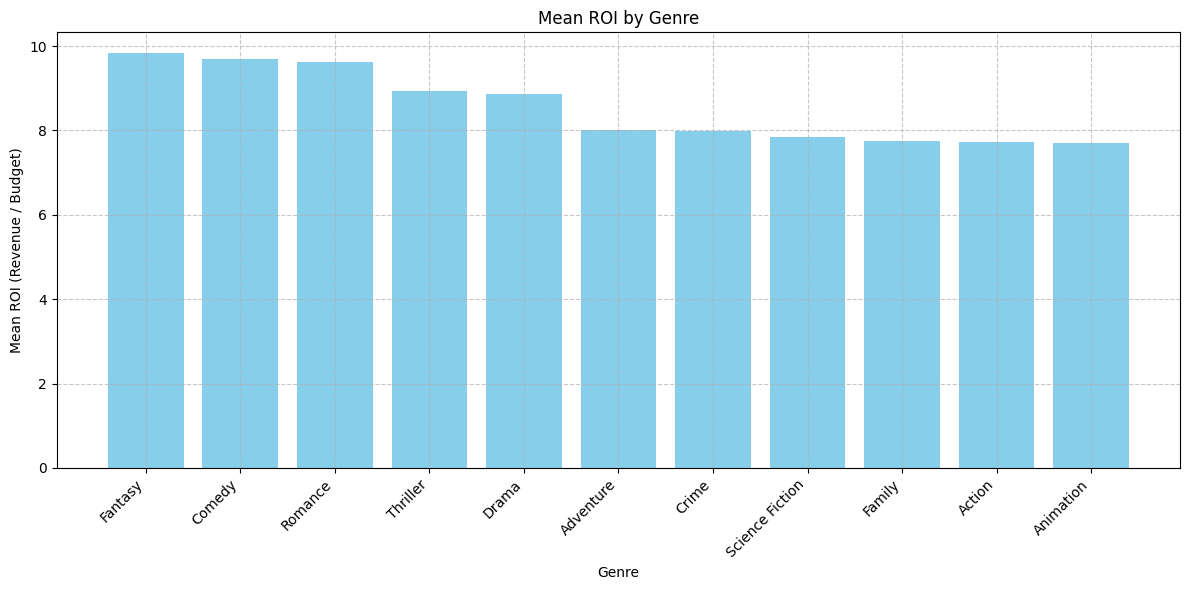

Saved roi_by_genre.png


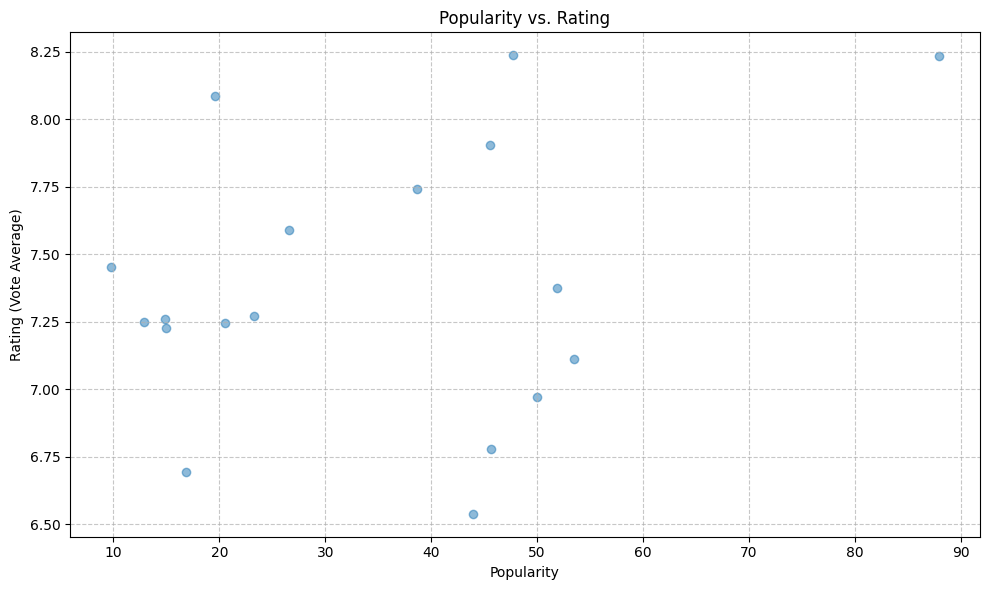

Saved popularity_vs_rating.png


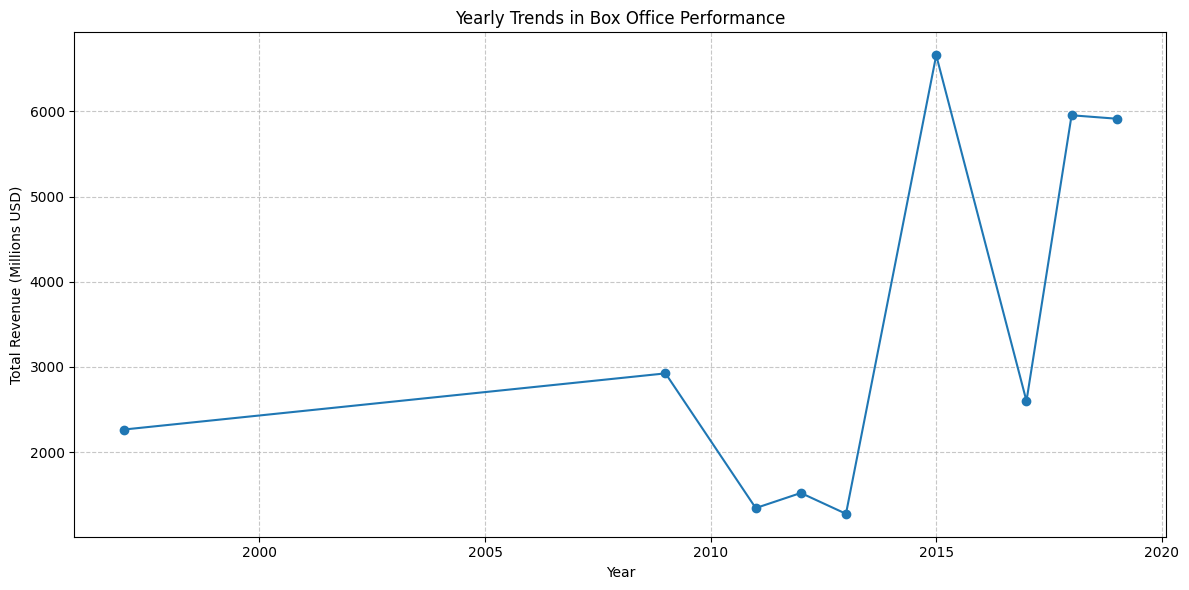

Saved yearly_box_office.png


<Figure size 1000x600 with 0 Axes>

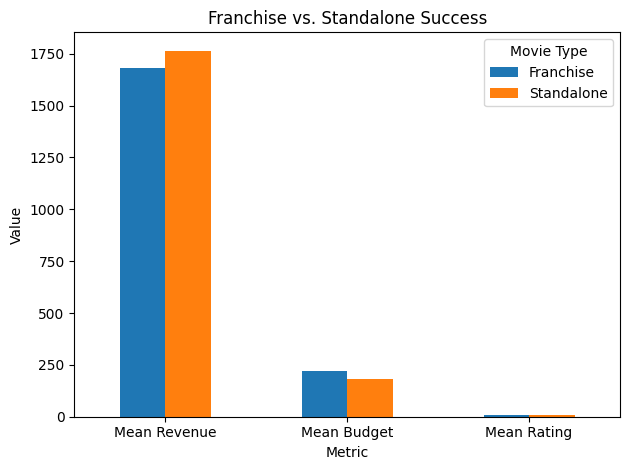

Saved franchise_vs_standalone.png


In [10]:
print("\nGenerating visualizations...")
plot_revenue_vs_budget(cleaned_data)
print("Saved revenue_vs_budget.png")

plot_roi_by_genre(cleaned_data)
print("Saved roi_by_genre.png")

plot_popularity_vs_rating(cleaned_data)
print("Saved popularity_vs_rating.png")

plot_yearly_box_office(cleaned_data)
print("Saved yearly_box_office.png")

plot_franchise_vs_standalone(cleaned_data)
print("Saved franchise_vs_standalone.png")

## Cleanup

- **Stop Spark session:** Releases resources by stopping the SparkSession.

In [11]:
# Stop the Spark session
spark.stop()
print("Analysis complete!")

Analysis complete!
